In [239]:
%matplotlib notebook
import numpy as np
from colicoords import load, save, Data, filter_binaries, data_to_cells, CellPlot, CellListPlot, CellList, IterCellPlot, iter_subplots
import matplotlib.pyplot as plt
import tifffile
import mahotas as mh
import re
import pickle
from tqdm.auto import tqdm

In [26]:
def chunk_list(l, sizes):
    prev = 0
    for s in sizes:
        result = l[prev:prev+s]
        prev += s
        yield result


def encode(cell, name):
    xs = np.clip(np.round(cell.data.data_dict[name]['x']).astype(int), 0, cell.data.shape[1] - 1)
    ys = np.clip(np.round(cell.data.data_dict[name]['y']).astype(int), 0, cell.data.shape[0] - 1)
    intensity = cell.data.data_dict[name]['intensity']
    pixels = cell.data.binary_img[ys, xs].astype(bool)

    encode_arr = (200 * np.arange(len(intensity[pixels])) + 1) ** 2
    return np.sum(intensity[pixels] * encode_arr)


def encode_intensity(cells):
    out_arr = np.empty(len(cells))
    for i, cell in enumerate(cells):
        s1 = encode(cell, 'storm_outer')
        s2 = encode(cell, 'storm_inner')

        out_arr[i] = s1 + s2

    return out_arr


def match_cells(gt_cells, m_cells):
        """Iterate though measured cells m_cells and tries to find corresponding cell in ground-truth cells"""
        gt_out, m_out = [], []
        f_out = []
        f1_out = []
        s_100_gt = []
        s_100_m = []

        # storm_int_gt = encode_intensity(gt_cells)
        # assert len(storm_int_gt) == len(np.unique(storm_int_gt))
        storm_int_gt = np.load('encoded.npy')
        st = np.load('storm_int.npy')
        img_number = np.load('img_number.npy')


        storm_int_m = encode_intensity(m_cells)
        zeros = storm_int_m == 0  # cells with zero intensity are false positive
        assert len(storm_int_m[~zeros]) == len(np.unique(storm_int_m[~zeros]))
        print('bools total', np.sum([zeros]))

        n = 0
        j = 0
        for k, (cell, int_val) in enumerate(zip(m_cells[~zeros], storm_int_m[~zeros])):
            try:
                i = list(storm_int_gt).index(int_val)
                #gt_out.append(gt_cells[i])
                m_out.append(cell)
            except ValueError:
                n += 1
                f_out.append(cell)

                c_n = int(re.findall(r'(\d+)', cell.name)[0])
                b = img_number == c_n

                st_c = cell.data.data_dict['storm_outer']['intensity']
                sums = [np.sum([elem in st_elem for elem in st_c]) for st_elem in st[b]]
                if sums and np.max(sums) > 100:
                    i = np.argmax(sums)
                    s_100_gt.append(gt_cells[b][i])
                    s_100_m.append(cell)
                    #gt_out.append(gt_cells[b][i])
                else:
                    f1_out.append(cell)
                    print('cell number', c_n)
                    print(np.sum(b))
                    print('sums', sums)

                    j += 1


                continue

        print('Identified {} cells, not found {} out of total {}'.format(len(gt_out), n, len(m_cells)))
        print("j", j)

        return gt_out, m_out, f_out, f1_out, s_100_gt, s_100_m


def match_all():
    print('Loading GT')
    #gt_cells = load('cells_final_selected.hdf5')
    for ph in [500]:
        print(f'Photons {ph}')

        m_cells = load('cell_obj/cell_ph_{}_raw.hdf5'.format(ph))
        print('Measured cells loaded')

        gt_match, m_match, failed, f1 = match_cells(m_cells)
        # save('cell_obj/gt_cells_ph_{}_match_raw.hdf5'.format(ph), CellList(gt_match))
        # save('cell_obj/m_cells_ph_{}_match_raw.hdf5'.format(ph), CellList(m_match))
        save('cell_obj/m_cells_ph_{}_fail_raw.hdf5'.format(ph), CellList(failed))
        save('cell_obj/m_cells_ph_{}_fail1_raw.hdf5'.format(ph), CellList(f1))


In [4]:
gt_cells = load('cells_final_selected.hdf5')

In [11]:
m_cells = load('cell_obj/cell_ph_500_raw.hdf5')

In [6]:
with open('temp_cell.pick', 'wb') as f:
    pickle.dump(gt_cells, f)

In [15]:
f1_cells = load('cell_obj/m_cells_ph_500_fail1_raw.hdf5')

In [18]:
len(f1_cells)

12

<IPython.core.display.Javascript object>


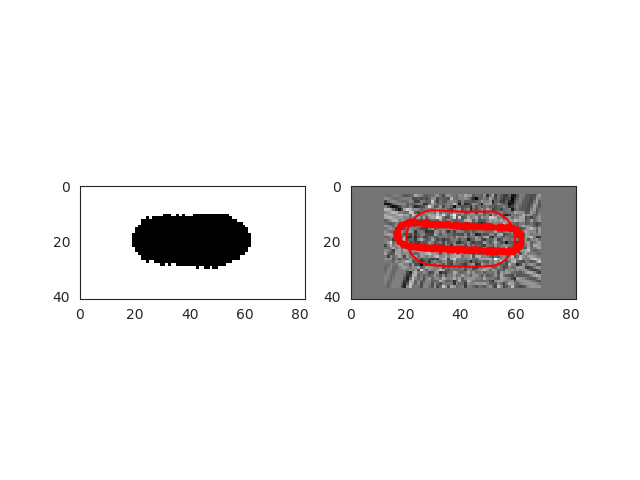

In [23]:
cp = IterCellPlot(f1_cells)
fig, axes = iter_subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')
fig.display()

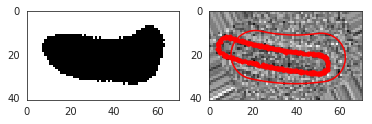

In [17]:
cp = CellPlot(f1_cells[0])
fig, axes = plt.subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')

In [13]:
61.69625811 % 1

0.6962581100000023

In [10]:
match_cells(m_cells)

STORMTable([(61.69625811, 24.90487934, 0, 158),
            (45.17857653, 35.39667132, 0, 212),
            (46.56703636, 23.3437708 , 0, 141),
            (23.87490561, 30.28025346, 0,  50),
            (26.92846979, 24.58465204, 0, 175),
            (27.05697131, 24.63709691, 0, 350),
            (56.12383698, 36.09177284, 0, 213),
            (41.46497707, 23.51364685, 0,  91),
            (30.64342201, 23.99791551, 0, 208),
            (63.61840497, 29.61551401, 0, 257),
            (28.64065579, 35.59670537, 0, 243),
            (37.42812821, 35.45853797, 0, 178),
            (54.36206304, 35.51233261, 0, 241),
            (52.69328087, 35.59265581, 0, 258),
            (47.56312906, 23.72552286, 0, 196),
            (42.86468045, 35.03421792, 0, 115),
            (31.68466284, 23.73382304, 0, 160),
            (62.86998095, 33.12767227, 0, 315),
            (34.45756222, 35.61021345, 0, 215),
            (51.85149375, 23.37694152, 0, 205),
            (33.8005067 , 23.71645738, 0

In [ ]:

img_number = np.array([int(re.findall(r'(\d+)', c.name)[0]) for c in gt_cells])

In [27]:
gt_out, m_out, f_out, f1_out, s_100_gt, s_100_m = match_cells(gt_cells, m_cells)

bools total 61
cell number 206
0
sums []
cell number 206
0
sums []
cell number 206
0
sums []
cell number 617
0
sums []
cell number 617
0
sums []
cell number 617
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
Identified 0 cells, not found 1540 out of total 6827
j 12


In [28]:
len(s_100_gt)

1528

<IPython.core.display.Javascript object>


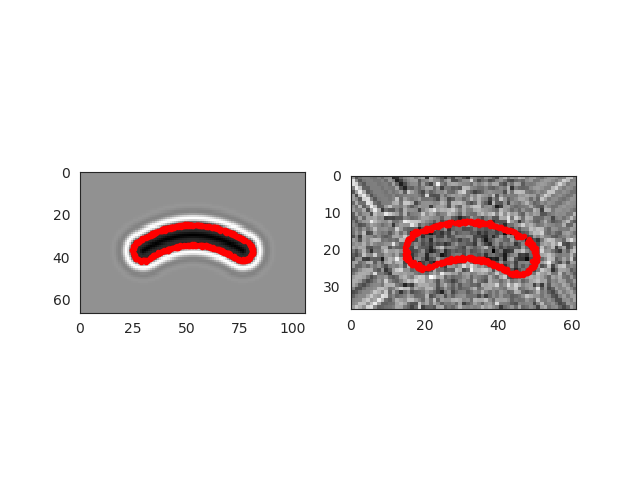

In [33]:
i = 1

fig, axes = plt.subplots(1, 2)
cp_gt = CellPlot(s_100_gt[i])
cp_m = CellPlot(s_100_m[i])
cp_gt.imshow('brightfield', ax=axes[0])
cp_gt.plot_storm(data_name='storm_inner', ax=axes[0])
cp_m.imshow('brightfield', ax=axes[1])
cp_m.plot_storm(data_name='storm_inner', ax=axes[1])

In [35]:
from sklearn.cluster import AffinityPropagation

X = np.array([[1, 2], [1, 4], [1, 0],[4, 2], [4, 4], [4, 0]])
clustering = AffinityPropagation().fit(X)
clustering 

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [36]:
clustering.labels_

array([0, 0, 0, 1, 1, 1])

In [37]:
storm_inner = np.load('storm_inner.npy')

In [315]:
st_f1 = storm_inner[storm_inner['frame'] == 3]

In [276]:
storm_inner['frame'].dtype

dtype('int64')

In [316]:
x, y = st_f1['x'], st_f1['y']

In [317]:
X = np.array([x,y]).T
X.shape

(5452, 2)

In [318]:
cluster = fc.linkage(X)

In [319]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(cluster, max_d, criterion='distance')
clusters



array([8, 8, 8, ..., 1, 1, 1], dtype=int32)

In [320]:
clustered_storm = [st_f1[clusters == i] for i in np.unique(clusters)]

<IPython.core.display.Javascript object>


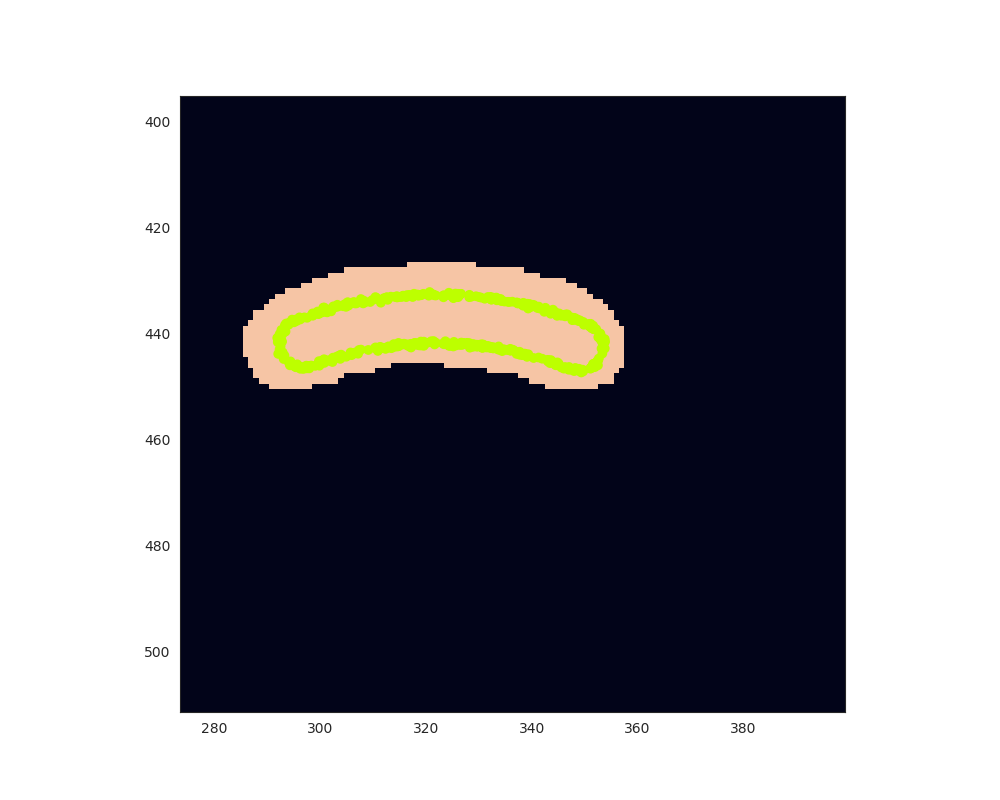

In [321]:
plt.figure(figsize=(10, 8))
plt.imshow(filtered_binary[2])
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [83]:
def encode(arr):
    encode_arr = (200 * np.arange(len(arr)) + 1) ** 2
    return np.sum(arr * encode_arr)

def encode_intensity(cells):
    out_arr = np.empty(len(cells), dtype=int)
    for i, cell in enumerate(cells):
        intensity = cell.data.data_dict['storm_inner']['intensity']
        out_arr[i] = encode(intensity)

    return out_arr

In [84]:
encoded_gt = encode_intensity(gt_cells[:9000])

In [85]:
encoded_gt[0]

494961152204958

In [322]:
encoded_storm = [encode(elem['intensity']) for elem in clustered_storm]

In [323]:
encoded_storm

[359772115925162,
 189873212965878,
 219105590976580,
 631652250169269,
 354711083075861,
 317769933409588,
 322563942261370,
 236225382618355,
 288056536549521,
 337519783078967,
 397426223601582]

In [ ]:
494961152204958

In [324]:
for _ in encoded_storm:
    print(np.argwhere(_ == encoded_gt))

[[34]]
[[28]]
[[33]]
[[27]]
[[30]]
[[29]]
[[32]]
[[24]]
[[25]]
[[31]]
[[26]]


In [326]:
s_cells = m_cells[img_numbers == 2]
len(s_cells)

10

In [102]:
orig_binary = tifffile.imread('binary_500photons_predicted.tif')
filtered_binary = filter_binaries(orig_binary, min_size=495, max_size=2006.4, min_minor=7.57, max_minor=17.3,
                                min_major=15.41, max_major=54.97)

In [244]:
binary = np.load('binary.npy')

In [251]:
bin_1000 = tifffile.imread('binary_1000photons_predicted.tif')


In [248]:
bf = tifffile.imread('bf_noise_500_photons.tif')

<IPython.core.display.Javascript object>


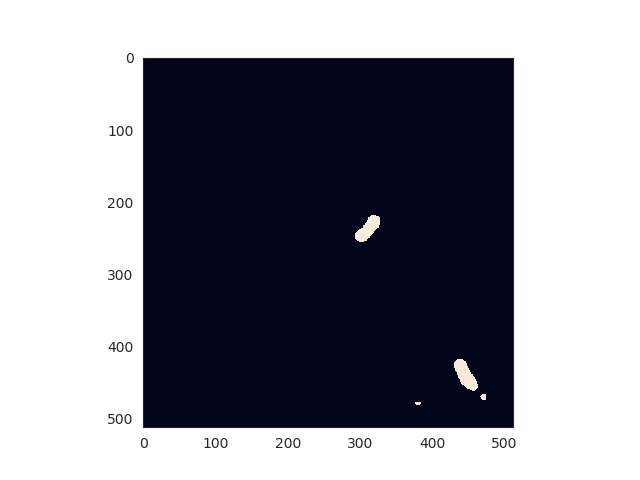

In [252]:
plt.figure()
plt.imshow(bin_1000[565])

<IPython.core.display.Javascript object>


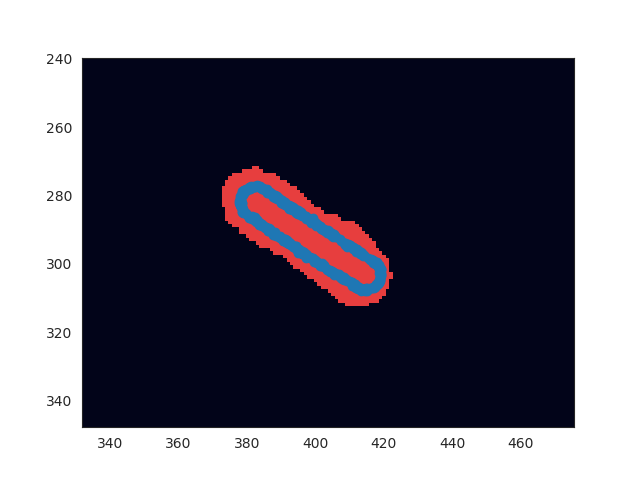

In [329]:
plt.figure()
plt.imshow(filtered_binary[2])
plt.scatter(clustered_storm[0]['x'], clustered_storm[0]['y'])
#plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism', alpha=0.1)  # plot points with cluster dependent colors

In [330]:
cell_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[1]) for cell in s_cells])
cell_numbers

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [332]:
coms_cells = [mh.center_of_mass(filtered_binary[2]==i) for i in cell_numbers]
coms_cells

[array([131.95797517, 145.15281757]),
 array([167.99817518, 286.30018248]),
 array([174.15835521, 141.48118985]),
 array([193.5424, 323.7584]),
 array([241.11815562,  40.61527378]),
 array([292.20412169, 397.44651619]),
 array([378.88564058,  60.53654342]),
 array([433.26796875, 241.28125   ]),
 array([438.71364318, 321.83883058]),
 array([457.04066543,  97.09519409])]

In [333]:
coms_storm = np.array([[np.mean(elem['y']), np.mean(elem['x'])] for elem in clustered_storm])
coms_storm

array([[292.58651973, 398.38989848],
       [169.24162281, 287.48547787],
       [195.26839995, 323.87284091],
       [131.42966805, 145.7902483 ],
       [175.17319879, 142.40281507],
       [240.89772317,  41.95729473],
       [187.78463974,  22.75932624],
       [433.11477046, 241.15312307],
       [439.84260598, 323.86179204],
       [379.29020054,  61.43659263],
       [457.75047096,  97.66124211]])

In [114]:
coms_storm[:, 1]

TypeError: list indices must be integers or slices, not tuple

In [334]:
coms_cells = np.array(coms_cells)

In [335]:
coms_cells

array([[131.95797517, 145.15281757],
       [167.99817518, 286.30018248],
       [174.15835521, 141.48118985],
       [193.5424    , 323.7584    ],
       [241.11815562,  40.61527378],
       [292.20412169, 397.44651619],
       [378.88564058,  60.53654342],
       [433.26796875, 241.28125   ],
       [438.71364318, 321.83883058],
       [457.04066543,  97.09519409]])

In [336]:
com_storm = coms_storm[0]
ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
ds
idx_m = np.argmin(ds)
idx_m, ds

(5, array([299.88422512, 167.58985658, 282.89099442, 124.0145081 ,
        361.45770788,   1.01793831, 348.70105791, 210.88953869,
        164.96424523, 343.25451918]))

In [ ]:
299.88422512 167.58985658 282.89099442 124.0145081  361.45770788
   1.01793831 348.70105791 210.88953869 164.96424523 343.25451918]
5 1.0179383111882379
[147.13482446   1.71787286 146.08705068  43.66065336 257.12085415
 164.95819494 308.96024507 268.03869501 271.65294514 345.07499054]
1 1.7178728604021802
[189.60236451  46.42596063 183.60922734   1.72978974 286.94433159
 121.6947815  321.03161313 251.92293591 243.45374026 346.34205646]
3 1.7297897415892358
[  0.82790479 145.19055519  42.94541524 188.49576783 151.96492875
 298.62903762 261.73011393 316.58315049 354.14198381 329.23203052]
0 0.827904787877112
[ 43.30263348 144.0761372    1.37087583 182.28350375 121.28248387
 280.61276948 219.54690928 276.38714727 318.82730355 285.48563759]
2 1.3708758336604383
[150.05727116 254.9858641  119.82966634 285.75232206   1.36000394
 359.17256731 139.23309174 277.01326779 342.73139967 223.06492202]
4 1.360003937207412
[134.52428479 264.28258946 119.50128255 301.05413834  56.24321096
 388.96518935 194.79915468 328.6546759  390.40224729 279.3288897 ]
4 56.2432109570071
[3.16087763e+02 2.68933200e+02 2.77475980e+02 2.53413797e+02
 2.77629482e+02 2.10436298e+02 1.88581938e+02 1.99715361e-01
 8.08797303e+01 1.46031282e+02]
7 0.19971536050636174
[355.99135305 274.42716533 322.25891014 246.30022769 346.00577637
 164.96009722 270.28862016  82.84184799   2.31666356 227.41781635]
8 2.316663559554673
[261.11613513 308.5578617  220.19584808 321.42647064 139.73203396
 347.11187514   0.98679143 187.7703391  267.09637037  85.53753942]
6 0.9867914325602283
[329.23578185 345.74707914 286.95762045 347.74391377 224.01741573
 342.4570109   87.1659608  145.69179654 224.98442609   0.90787348]
9 0.9078734766954567

com_storm

In [1]:
for com_storm in coms_storm:
    ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
    ds
    idx_m = np.argmin(ds)
    print(ds)
    print(idx_m, np.min(ds))

NameError: name 'coms_storm' is not defined

In [172]:
com_storm

array([401.2747831 , 343.15174928])

In [116]:
p = coms_cells[0]
ds = np.sqrt((p[0] - coms_storm[:, 0])**2 + (p[1] - coms_storm[:, 1])**2)
ds

array([414.79811931, 460.91641351, 235.4500514 , 165.77888013,
       249.65962717, 252.2035274 , 295.69431098,   1.03255486,
       114.46422437, 166.74710637])

In [118]:
match = np.argmin(ds)
match

7

<IPython.core.display.Javascript object>


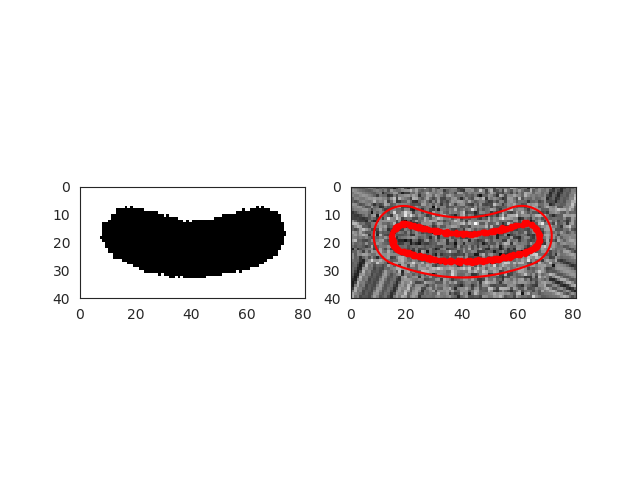

In [95]:
cp = IterCellPlot(s_cells)
fig, axes = iter_subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')
fig.display()

In [68]:
binary_gt = np.load('binary.npy')

In [69]:
binary_gt.shape

(1000, 512, 512)

In [70]:
c_max = 0
for b in binary_gt:
    c_max += len(np.unique(b)) - 1
c_max

8803

In [313]:
def match_cells(gt_cells, m_cells, storm_input, filtered_binaries, max_d=3): 
    img_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[0]) for cell in m_cells])
    encoded_gt = encode_intensity(gt_cells[:9000])
    
    d_ = []
    
    gt_matched, m_matched = [], []
    for i in tqdm(np.unique(storm_input['frame'])[:5]):  # Iteration starts at 1 (ImageJ indexing)
        st_elem = storm_input[storm_input['frame'] == i].copy()
        X = np.array([st_elem['x'], st_elem['y']]).T.copy()
        linkage = fc.linkage(X)
        clusters = fcluster(linkage, max_d, criterion='distance')
        clustered_st = [st_elem[clusters == i] for i in np.unique(clusters)]
        encoded_storm = [encode(elem['intensity']) for elem in clustered_st]
        
        s_cells = m_cells[img_numbers == (i - 1)]
        if len(s_cells) == 0:
            print('No cells, img {}'.format(i))
            continue
            
        cell_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[1]) for cell in s_cells])
        binary_img = filtered_binaries[i - 1]
        coms_cells = np.array([mh.center_of_mass(binary_img == j) for j in cell_numbers])
        
        bordering = 0
        too_far = 0
        for cluster, code in zip(clustered_storm, encoded_storm):
            
            # Find the GT cell
            idx_gt = np.argwhere(code == encoded_gt)
            if len(idx_gt) == 0:
                #print('Cluster not in cells, probably bordering cell')
                bordering += 1
                continue
            else:
                gt_cell = gt_cells[idx_gt[0][0]]
            
            print('idx', i)
            print(coms_cells)
            
            # Find the M cell
            com_storm = [np.mean(cluster['y']), np.mean(cluster['x'])]
            ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
            print('ds', ds)
                       
            idx_m = np.argmin(ds)
            if np.min(ds) > 10:
                print('too far')
                too_far += 1
                d_.append(np.min(ds))
                continue
            else:
                m_cell = s_cells[idx_m]
                
            gt_matched.append(gt_cell)
            m_matched.append(m_cell)
        if not bordering == too_far:
            print(bordering, too_far)
            print('Failure in index {}'.format(i))
            
        plt.figure()
        plt.imshow(binary_img)
        for c in clustered_st:
            plt.scatter(c['x'], c['y'])
            
    return gt_matched, m_matched, d_

idx 1
[[ 40.49176471 138.47372549]
 [110.85223368 379.36254296]
 [131.52900688 275.6833825 ]
 [140.27559055  81.00262467]
 [163.46387833 354.10931559]
 [263.68655529 210.90453461]
 [400.55934195 342.28789659]
 [434.93948718 374.87487179]]
ds [456.34222523 328.35632401 318.90230403 409.45346298 275.34436744
 230.7902399   42.64476668  14.05463184]
too far
idx 1
[[ 40.49176471 138.47372549]
 [110.85223368 379.36254296]
 [131.52900688 275.6833825 ]
 [140.27559055  81.00262467]
 [163.46387833 354.10931559]
 [263.68655529 210.90453461]
 [400.55934195 342.28789659]
 [434.93948718 374.87487179]]
ds [334.70340559 127.32833081 170.19332764 343.57595084  90.99384755
 202.80660093 180.33474195 204.20766328]
too far
idx 1
[[ 40.49176471 138.47372549]
 [110.85223368 379.36254296]
 [131.52900688 275.6833825 ]
 [140.27559055  81.00262467]
 [163.46387833 354.10931559]
 [263.68655529 210.90453461]
 [400.55934195 342.28789659]
 [434.93948718 374.87487179]]
ds [247.40835199 232.28628133 156.08122374 190.

<IPython.core.display.Javascript object>


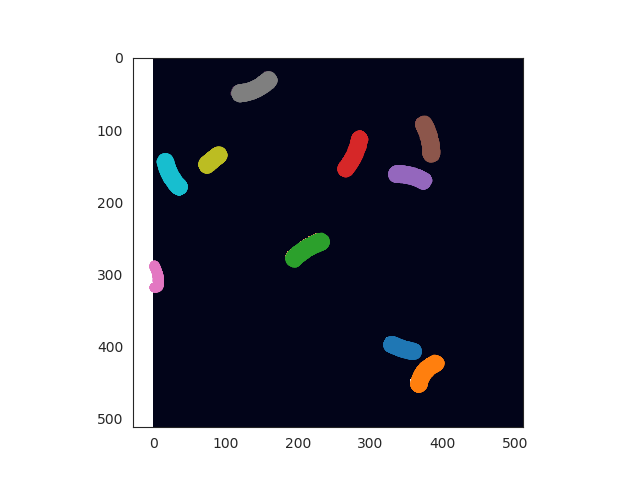

idx 2
[[ 14.79757785 110.92387543]
 [ 45.93973214 281.69754464]
 [ 89.36314068 179.64994547]
 [137.91101322 154.81674009]
 [155.20817121  53.91439689]
 [247.68387097  91.32419355]
 [233.99380165 411.67837466]
 [275.02203065 214.44061303]
 [439.06427689 358.25710754]]
ds [492.35255616 400.76612556 393.77094561 364.87317426 418.19073347
 330.75498929 210.81845783 219.93914929   3.09921454]
idx 2
[[ 14.79757785 110.92387543]
 [ 45.93973214 281.69754464]
 [ 89.36314068 179.64994547]
 [137.91101322 154.81674009]
 [155.20817121  53.91439689]
 [247.68387097  91.32419355]
 [233.99380165 411.67837466]
 [275.02203065 214.44061303]
 [439.06427689 358.25710754]]
ds [3.72072163e+02 2.28566569e+02 2.73320777e+02 2.74128199e+02
 3.66207095e+02 3.20499872e+02 1.54739060e-01 2.01307073e+02
 2.11824400e+02]
idx 2
[[ 14.79757785 110.92387543]
 [ 45.93973214 281.69754464]
 [ 89.36314068 179.64994547]
 [137.91101322 154.81674009]
 [155.20817121  53.91439689]
 [247.68387097  91.32419355]
 [233.99380165 411.

<IPython.core.display.Javascript object>


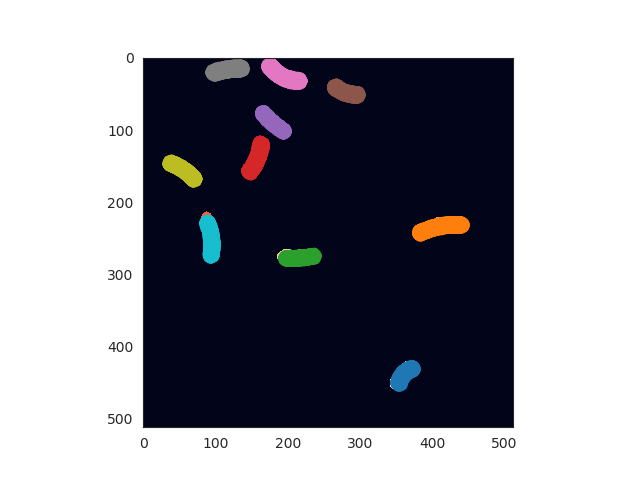

idx 3
[[131.95797517 145.15281757]
 [167.99817518 286.30018248]
 [174.15835521 141.48118985]
 [193.5424     323.7584    ]
 [241.11815562  40.61527378]
 [292.20412169 397.44651619]
 [378.88564058  60.53654342]
 [433.26796875 241.28125   ]
 [438.71364318 321.83883058]
 [457.04066543  97.09519409]]
ds [375.27885516 280.92197664 343.98499047 248.03410392 376.70400969
 150.89368671 306.69187934 120.17857595  39.49756331 264.87601052]
too far
idx 3
[[131.95797517 145.15281757]
 [167.99817518 286.30018248]
 [174.15835521 141.48118985]
 [193.5424     323.7584    ]
 [241.11815562  40.61527378]
 [292.20412169 397.44651619]
 [378.88564058  60.53654342]
 [433.26796875 241.28125   ]
 [438.71364318 321.83883058]
 [457.04066543  97.09519409]]
ds [285.27446187 141.5847204  276.61416111  96.67133188 370.9859932
  59.83680308 379.70611287 262.05736883 223.45630168 385.48265421]
too far
idx 3
[[131.95797517 145.15281757]
 [167.99817518 286.30018248]
 [174.15835521 141.48118985]
 [193.5424     323.7584   

<IPython.core.display.Javascript object>


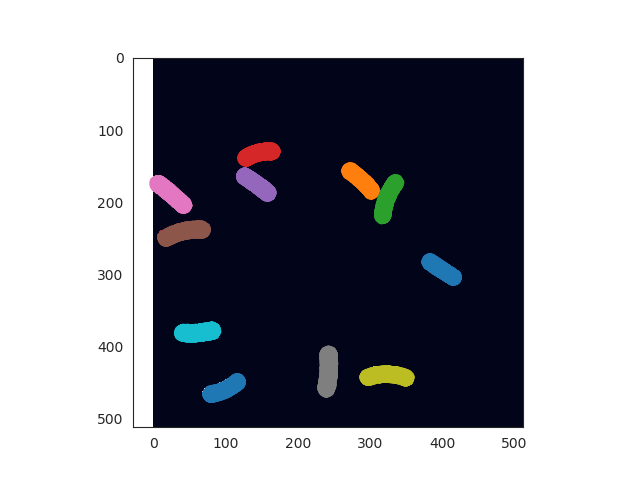

idx 4
[[152.1120944  422.43756146]
 [350.37292465 239.40102171]]
ds [293.04206441 150.5731438 ]
too far
idx 4
[[152.1120944  422.43756146]
 [350.37292465 239.40102171]]
ds [ 82.65947153 207.75208352]
too far
0 2
Failure in index 4


<IPython.core.display.Javascript object>


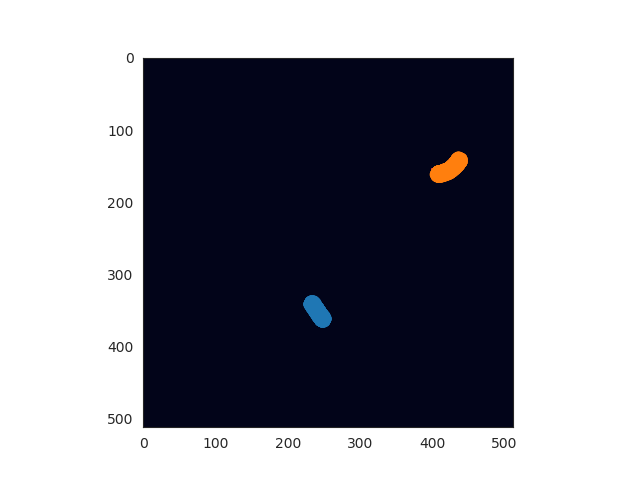

idx 5
[[ 26.59496327 245.80482686]
 [149.42628774 295.65541741]
 [181.31785714 134.93035714]
 [199.91494532 394.86148238]
 [325.99576271 199.06355932]
 [337.47372263 418.99708029]
 [384.59268005 391.11570248]
 [430.42657343 444.98111888]
 [434.01008403 155.65714286]]
ds [265.52479097 143.48823313 281.58502869  37.98843583 231.51201161
 103.6933885  151.92177402 199.20533547 324.74182706]
too far
idx 5
[[ 26.59496327 245.80482686]
 [149.42628774 295.65541741]
 [181.31785714 134.93035714]
 [199.91494532 394.86148238]
 [325.99576271 199.06355932]
 [337.47372263 418.99708029]
 [384.59268005 391.11570248]
 [430.42657343 444.98111888]
 [434.01008403 155.65714286]]
ds [250.80839808 149.41551086 124.05591754 194.58808421  53.05758901
 212.62080154 206.62883403 276.76890772 169.38921287]
too far
idx 5
[[ 26.59496327 245.80482686]
 [149.42628774 295.65541741]
 [181.31785714 134.93035714]
 [199.91494532 394.86148238]
 [325.99576271 199.06355932]
 [337.47372263 418.99708029]
 [384.59268005 391.115

<IPython.core.display.Javascript object>


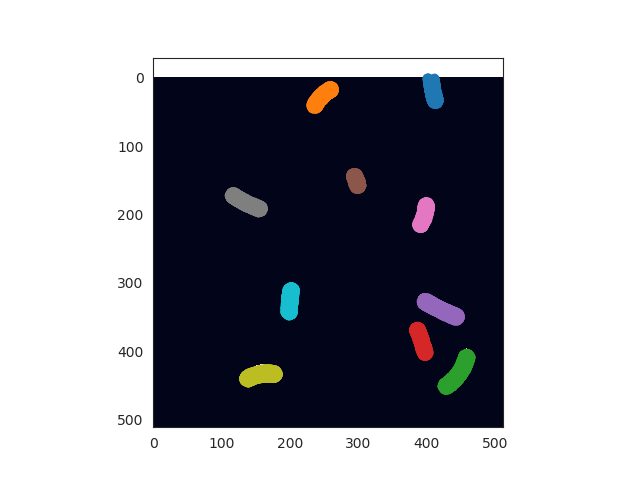

In [314]:
gt, m, dist = match_cells(gt_cells[:9000], m_cells, storm_inner, filtered_binary, max_d=5)

In [224]:
len(gt)

8

<IPython.core.display.Javascript object>


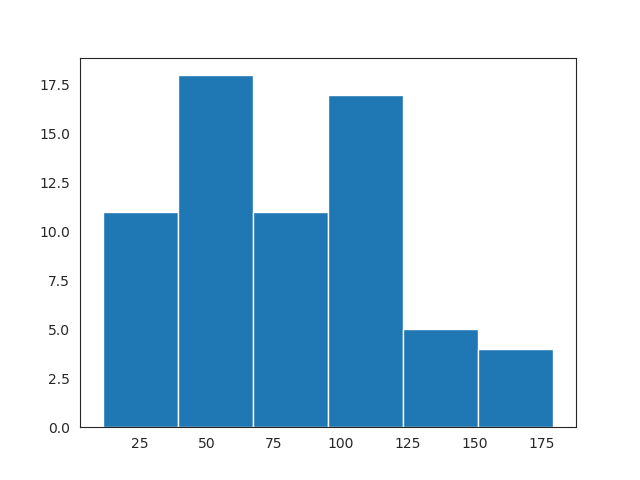

(array([11., 18., 11., 17.,  5.,  4.]),
 array([ 11.14716261,  39.17318176,  67.19920091,  95.22522007,
        123.25123922, 151.27725837, 179.30327752]),
 <a list of 6 Patch objects>)

In [266]:
plt.figure()
plt.hist(dist, bins='fd')

In [192]:
gt


<IPython.core.display.Javascript object>


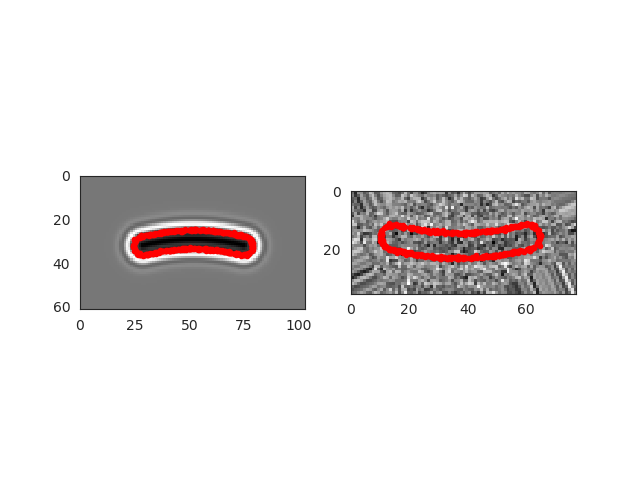

In [229]:
i = 3

fig, axes = plt.subplots(1, 2)
cp_gt = CellPlot(gt[i])
cp_m = CellPlot(m[i])
cp_gt.imshow('brightfield', ax=axes[0])
cp_gt.plot_storm(data_name='storm_inner', ax=axes[0])
cp_m.imshow('brightfield', ax=axes[1])
cp_m.plot_storm(data_name='storm_inner', ax=axes[1])

In [230]:
len(m[i].data.data_dict['storm_inner']), len(gt[i].data.data_dict['storm_inner'])

(547, 547)

In [232]:
m[i].optimize('storm_inner')

<IPython.core.display.Javascript object>


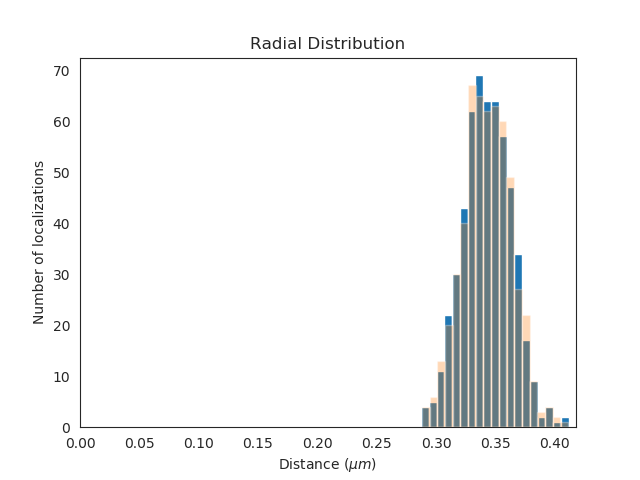

(array([ 4.,  6., 13., 20., 30., 40., 67., 65., 62., 63., 60., 49., 27.,
        22.,  9.,  3.,  4.,  2.,  1.]),
 array([0.28813344, 0.29460312, 0.30107279, 0.30754246, 0.31401214,
        0.32048181, 0.32695148, 0.33342116, 0.33989083, 0.3463605 ,
        0.35283018, 0.35929985, 0.36576953, 0.3722392 , 0.37870887,
        0.38517855, 0.39164822, 0.39811789, 0.40458757, 0.41105724]),
 <a list of 19 Patch objects>)

In [236]:
plt.figure()
cp_m.hist_r_storm(norm_x=False)
cp_gt.hist_r_storm(norm_x=False, alpha=0.3)